# Лабораторная работа №4

# ФИО:  Котиков Фёдор Владимирович  
# Группа: БИВТ-20-4

# Вариант: keremberke/shoe-classification

# Дата сдачи: 04.06.2023

**Что необходимо сделать**:
1. Загрузить датасет (вариант смотреть [здесь](https://docs.google.com/spreadsheets/d/1pFk1qZJtMrV8GWUmdSjV5Kz6JnFdBQDShErFZ337FDc/edit?usp=sharing))
2. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем, привести примеры картинок (картинки можно визуализировать после шага 3, когда у вас будет красивый датасет).
3. Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо сделать препроцессинг данных: нормализовать данные, добавить аугментации к данным и пр.).
4. Оформить датасет из шага 3 в Dataloader.
5. Реализовать архитектуру собственной нейросети и натренировать ее на датасете (можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали улучшаться).
6. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть [тут](https://pytorch.org/vision/stable/models.html)).
7. Посчитать метрики качества финальной модели, сделать выводы.

In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.6 MB/s eta 0:00:00


In [2]:
#импортируем все необходимое далее (моежт есть лишнее, не очень тут удобно за этим следить)
"""
как уже понял, не лучшее решение писать все импорты в одном месте, но уже поздно менять
"""

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Normalize, Lambda
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch import nn, optim
import time
import matplotlib
from matplotlib import pyplot as plt
import torchvision.models as models

# 1. Загрузить датасет
# `Выполнено`

In [3]:
#загружаем датасет
dataset = load_dataset("keremberke/shoe-classification", name="full")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset shoe-classification downloaded and prepared to /root/.cache/huggingface/datasets/keremberke___shoe-classification/full/1.0.0/fb99532b93009eff01fb830c335a09fd117854f4d6933730a5b1c101c3fe2a32. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# 2. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем. Привести примеры картинок
# `Выполнено`

In [4]:
#выведем данные одного из объектов датасета для дальнейшего анализа
print(dataset['train'][0])

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/533ac829e3e26ab7d02f9681d9eaaac412687d2e0ded0eacd54564df2384f51e/adidas/100_jpg.rf.a3bbc0f1769872ccb6cf2bd4bef1b45e.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=240x240 at 0x7FAE21B7CD60>, 'labels': 1}


Датасет "shoe-classification" содержит изображения трех типов: "adidas", "converse", "nike". Каждое изображение имеет разрешение 240x240 пикселей, чего должно быть более чем достаточно для определения типа обуви по представленной картинке. Изображения растровые, предсавлены в цветовом формате RGB. Некоторые изображения, для поддержания формата 240x240, ужаты.

Также, заметим, датасет уже заранее разделен на ['train': 576, 'test': 83, 'valid': 166]

Постановка задачи: разработка модели машинного обучения, которая будет способна отличать "adidas", "converse" и "nike" на основе входных изображений. Иными словами, написать классификатор, который будет принимать на вход изображение и возвращаеть его тип.

# `Выведем на экран графическое окно со всеми типами обуви:`

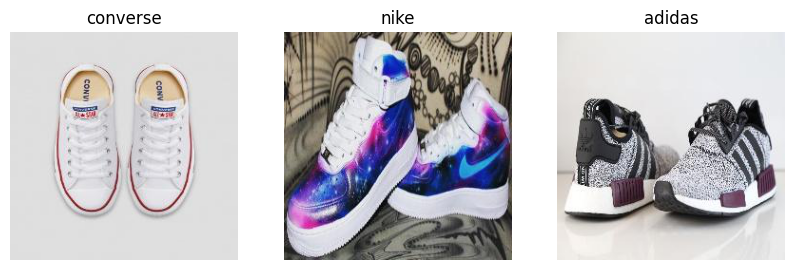

In [5]:
#составим словарь
labels_map = {
    0: "converse",
    1: "adidas",
    2: "nike"
}

#создадим объект графического окна
figure = plt.figure(figsize=(10, 10))
#установим число столбцов и строк сетки изображений
cols, rows = 3, 1
#зададим переменные, отвечающие за то, было ли уже добавлено изображение 
#    определенного типа в графическое окно
converseBeen, adidasBeen, nikeBeen = False, False, False

loop = 1;
#размер намбора и процентное содержание каждого типа позволяют делать так
while (not converseBeen or not adidasBeen or not nikeBeen):
    #получаем индекс рандомного объекта тестовых данных
    sample_idx = torch.randint(len(dataset['train']), size=(1,)).item()
    #сохраняем изображение и метку по полученному индексу
    img = dataset['train'][sample_idx]['image']
    label = dataset['train'][sample_idx]['labels']
    
    #проверяем, не было ли уже ранее добавлено изображение этого типа
    if (label == 0):
        if (converseBeen):
            continue
        else:
            converseBeen = True
    elif (label == 1):
        if (adidasBeen):
            continue
        else:
            adidasBeen = True
    else:
        if (nikeBeen):
            continue
        else:
            nikeBeen = True
    
    #создаем подграфик с заголовком в виде типа изображения и без осей
    figure.add_subplot(rows, cols, loop)
    plt.title(labels_map[label])
    plt.axis("off")
    #отображаем нужно изображение на подграфике
    plt.imshow(img)
    loop += 1
plt.show()

# 3. Оформить датасет в виде объекта класса Dataset из PyTorch
# `Выполнено`

In [6]:
#создаем класс - подкласс Dataset
class ShoesDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        #принимаем набор данных, преобразование и в качестве параметров
        self.data = dataset
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        #возвращаем длину датасета
        return len(self.data)
    
    def __getitem__(self, idx):
        #возвращаем элемент и его метку по индексу
        img = self.data[idx]['image']
        label = self.data[idx]['labels']
        
        #при необходимости преобразовываем
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        
        return img, label
        

In [7]:
#определяем переменную для преобразования изображений и создаем последовательную цепочку преобразований
# - преобразуем изображение в черно-белый формат, чтобы было проще (да и цвета тут, по идее, большой роли не играют)
# - преобразовываем изображение в тензор (с pil не работаем)
# - нормализуем значения пикселей
transform = transforms.Compose([
    transforms.Grayscale(),  # Преобразование в черно-белое изображение
    transforms.Resize((120, 120)),  
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize((0.5), (0.5)),  # Нормализация значений пикселей
])
"""
нормализация проводится путем вычитания среднего значеия (0.5) и деления на 
стандартное отклонение (0.5) для каждого канала цвета (RGB). Это помогает 
стандартизировать значения пикселей и улучшает обучение нейронной сети.
"""

#определяем переменную для преобразования целевых меток в желаемый формат
#устанавливаем 1 в индексе целевой метки, в остальных - нули
target_transform=Lambda(lambda y: torch.zeros(3, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))


# `Создадим экземпляры и продемонстрируем формат предоставления данных экземпляров:`

In [8]:
#создаем объекты класса ShoesDataset, помещаем тренировочные и тестовые данные
dataset_train = ShoesDataset(dataset['train'], transform=transform, target_transform=target_transform)
dataset_test = ShoesDataset(dataset['test'], transform=transform, target_transform=target_transform)

In [9]:
#представим полученный формат
X_sample, y_sample = dataset_train[0] #изображение/метка

In [10]:
torch.set_printoptions(edgeitems=float('inf'))
X_sample

tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.00

In [11]:
y_sample

tensor([0., 1., 0.])

In [12]:
print(X_sample.shape)
print(y_sample.shape)

torch.Size([1, 120, 120])
torch.Size([3])


# 4. Оформить датасет из шага 3 в Dataloader
# `Выполнено`

In [13]:
#создаем экземпляры DataLoader для dataset_train и dataset_test
# - данные будут разделены на пакеты по 64 элемента (для тренировочных данных это 9 пакетов)
# - "shuffle=True" - данные будут перемешаваться перед каждой эпохой обучения
train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=64, shuffle=True)

# `Отображаем первый элемент первого batch-а:`

Feature batch shape: torch.Size([64, 1, 120, 120])
Labels batch shape: torch.Size([64, 3])


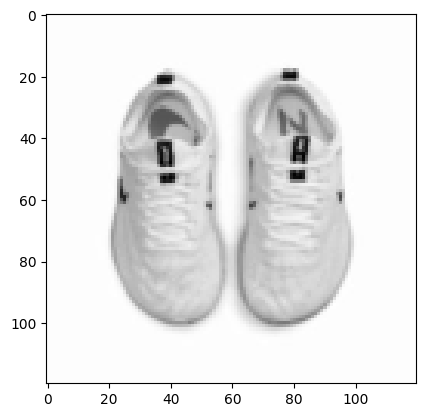

Label: tensor([0., 0., 1.])


In [14]:
#извлекаем следующий элемент (первую партию батчей) из итератора для train_dataloader
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}") #shape изображений
print(f"Labels batch shape: {train_labels.size()}") #shape меток
#извлекаем первый элемент партии изображений и удаляем размерность единицы из тензора
img = train_features[0].squeeze()
#извлекаем первый элемент партии меток
label = train_labels[0]
#записываем вывод изображения
plt.imshow(img, cmap="gray")
#отображаем изображение на экран
plt.show()
print(f"Label: {label}")

# 5. Реализовать архитектуру собственной нейросети и натренировать ее на датасете
# `Выполнено`


In [15]:
#устанавливаем device в значение cuda, если CUDA доступен, иначе в значение cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [16]:
'''
class NNClassifier(nn.Module):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.bn = nn.BatchNorm1d(120*120)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(120*120, 8192),
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
            #nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.bn(x)
        logits = self.linear_relu_stack(x)
        return logits
'''
class NNClassifier(nn.Module):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32*30*30, 4096),
            nn.ReLU(),
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        logits = self.fc_layers(x)
        return logits


In [17]:
model = NNClassifier().to(device)

In [18]:
learning_rate = 0.001
batch_size = 64
epochs = 250

In [19]:
loss_fn = nn.CrossEntropyLoss()

In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer, start_time):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * len(X)
            elapsed_time = (time.time() - start_time) / 60
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] Прошло {elapsed_time:>3f} минут")

def test_loop(dataloader, model, loss_fn, plot1, plot2):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            y = torch.argmax(y, dim=1)
            correct += (pred.argmax(1) == y).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    plot1.append(100*correct)
    plot2.append(test_loss)

In [22]:
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [23]:
plot1 = []
plot2 = []

In [24]:
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, start_time)
    test_loop(test_dataloader, model, loss_fn, plot1, plot2)
print("Done!")

Epoch 1
-------------------------------
loss: 1.093358  [    0/  576] Прошло 0.116572 минут
loss: 1.093727  [   64/  576] Прошло 0.120334 минут
loss: 1.098782  [  128/  576] Прошло 0.124135 минут
loss: 1.093747  [  192/  576] Прошло 0.127893 минут
loss: 1.095516  [  256/  576] Прошло 0.131673 минут
loss: 1.093983  [  320/  576] Прошло 0.135280 минут
loss: 1.098127  [  384/  576] Прошло 0.139032 минут
loss: 1.096480  [  448/  576] Прошло 0.142708 минут
loss: 1.095997  [  512/  576] Прошло 0.146378 минут
Test Error: 
 Accuracy: 45.8%, Avg loss: 1.092807 

Epoch 2
-------------------------------
loss: 1.095070  [    0/  576] Прошло 0.154538 минут
loss: 1.095905  [   64/  576] Прошло 0.158237 минут
loss: 1.091193  [  128/  576] Прошло 0.161791 минут
loss: 1.094310  [  192/  576] Прошло 0.165724 минут
loss: 1.098597  [  256/  576] Прошло 0.169409 минут
loss: 1.094179  [  320/  576] Прошло 0.173222 минут
loss: 1.093909  [  384/  576] Прошло 0.176926 минут
loss: 1.092376  [  448/  576] Прошло

# `Продемонстрируем результаты графическим путем`

In [27]:
y = []
for i in range(250):
  y.append(i+1)

Accuracy %


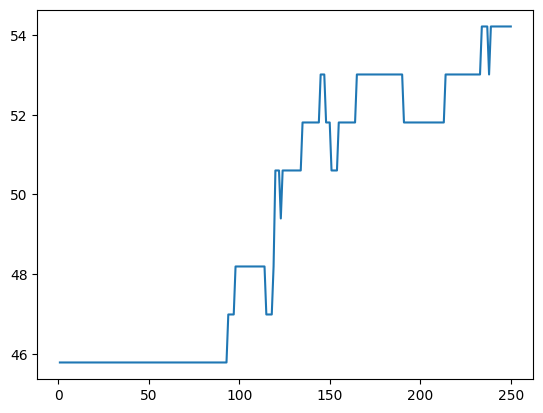

loss


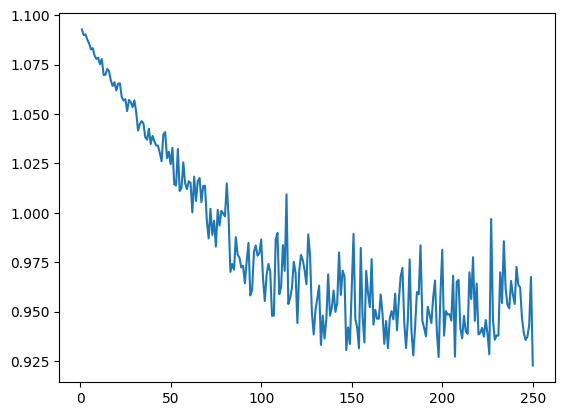

In [28]:
print("Accuracy %")
plt.plot(y, plot1)
plt.show()
print("loss")
plt.plot(y, plot2)
plt.show()

# 6. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть [тут](https://pytorch.org/vision/stable/models.html)).
# `Выполнено`

Transfer Learning представляет собой метод, при котором предварительно обученная модель, заранее обученная на достаточном наборе данных, используется в качестве основы для обучения новой модели на другом наборе данных, где новая модель должна решать схожую задачу.

In [29]:
#загрузка предварительно обученной модели ResNet
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


In [30]:
"""
#замораживаем параметры модели, чтобы не обновлять их в процессе обучения
for param in model.parameters():
    param.requires_grad = False
"""

'\n#замораживаем параметры модели, чтобы не обновлять их в процессе обучения\nfor param in model.parameters():\n    param.requires_grad = False\n'

In [31]:
#заменяем последний полносвязный слой модели на новый
num_classes = 3
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [32]:
model = model.to(device)

In [33]:
#определяем оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [34]:
transform = transforms.Compose([
    transforms.Resize((120, 120)),  
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Нормализация значений пикселей
])
target_transform=Lambda(lambda y: torch.zeros(3, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))

In [35]:
dataset_train = ShoesDataset(dataset['train'], transform=transform, target_transform=target_transform)
dataset_test = ShoesDataset(dataset['test'], transform=transform, target_transform=target_transform)

In [36]:
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [37]:
def train_loop(dataloader, model, loss_fn, optimizer, start_time):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * len(X)
            elapsed_time = (time.time() - start_time) / 60
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] Прошло {elapsed_time:>3f} минут")

In [38]:
def test_loop_tl(dataloader, model, loss_fn, plot3, plot4):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            y = torch.argmax(y, dim=1)
            correct += (pred.argmax(1) == y).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Точность тестирования: {(100*correct):>0.1f}%, Средний loss: {test_loss:>8f}\n")
    plot3.append(100*correct)
    plot4.append(test_loss)

    return plot3, plot4

In [40]:
plot3 = []
plot4 = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, start_time)
    plot3, plot4 = test_loop_tl(test_dataloader, model, loss_fn, plot3, plot4)
print("Done!")

Epoch 1
-------------------------------
loss: 0.819220  [    0/  576] Прошло 0.005678 минут
loss: 0.961230  [   64/  576] Прошло 0.015261 минут
loss: 1.032293  [  128/  576] Прошло 0.025869 минут
loss: 0.729432  [  192/  576] Прошло 0.032330 минут
loss: 0.926713  [  256/  576] Прошло 0.038877 минут
loss: 0.772027  [  320/  576] Прошло 0.045498 минут
loss: 0.805858  [  384/  576] Прошло 0.051980 минут
loss: 0.821505  [  448/  576] Прошло 0.057809 минут
loss: 0.823559  [  512/  576] Прошло 0.062792 минут
Точность тестирования: 68.7%, Средний loss: 0.813715

Epoch 2
-------------------------------
loss: 0.657736  [    0/  576] Прошло 0.073196 минут
loss: 0.639015  [   64/  576] Прошло 0.077995 минут
loss: 0.631622  [  128/  576] Прошло 0.082784 минут
loss: 0.631971  [  192/  576] Прошло 0.087624 минут
loss: 0.595013  [  256/  576] Прошло 0.092508 минут
loss: 0.627841  [  320/  576] Прошло 0.097233 минут
loss: 0.613789  [  384/  576] Прошло 0.102113 минут
loss: 0.602844  [  448/  576] Прош

Accuracy %


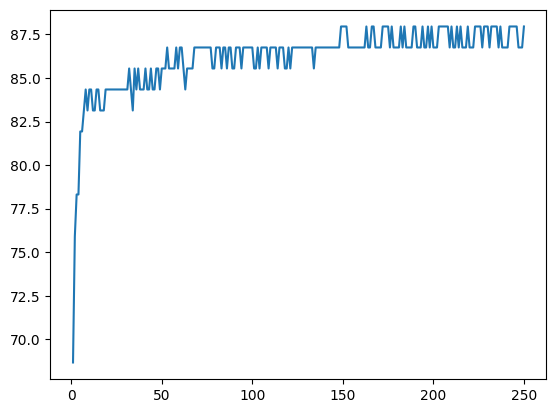

loss


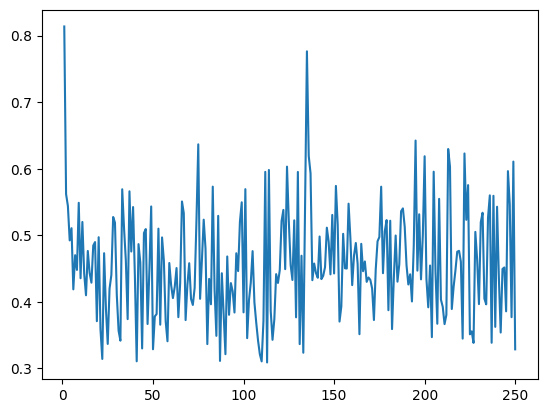

In [41]:
print("Accuracy %")
plt.plot(y, plot3)
plt.show()
print("loss")
plt.plot(y, plot4)
plt.show()

# 7. Посчитать метрики качества финальной модели, сделать выводы.
# `Выполнено`


Как можно заметить, моя модель значительно уступает Transfer Learning модели.
Значения моей модели после обучения после обучения:
  - loss: 0.922776
  - accurancy: 54.2%
Значения Transfer Learning модели:
  - loss: 0.328562
  - accurancy: 88.0%

Однако, для простой архитектуры и относительно небольшого времени обучения моя модель показала довольно неплохие результаты.